Test compositional lotka volterra algorithm on human gut time series (female test person).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl

from compositional_lotka_volterra import *

In [4]:
Y = pkl.load(open("data/bucci/Y_cdiff-denoised.pkl", "rb"))
U = pkl.load(open("data/bucci/U_cdiff.pkl", "rb"))
T = pkl.load(open("data/bucci/T_cdiff.pkl", "rb"))

In [5]:
Y = [np.sum(Y, axis=0)]
T = [T[0]]
# Print the result
print(Y)

[array([[4.23850956e+03, 0.00000000e+00, 7.44301161e+03, 1.87330076e+03,
        2.83216582e+02, 1.32656058e+04, 5.18323646e+04, 6.17457450e+03,
        4.22747721e+02, 2.11947185e+04, 8.28640568e+04, 8.75102120e+04,
        3.23361023e+02, 2.05738240e+04],
       [4.02397346e+03, 0.00000000e+00, 7.44571464e+03, 1.67279103e+03,
        5.59864625e+02, 1.38666242e+04, 5.60943231e+04, 1.20881624e+04,
        4.36216985e+02, 2.13878049e+04, 7.33661785e+04, 8.23833276e+04,
        2.13580070e+02, 1.95986156e+04],
       [2.64138838e+03, 0.00000000e+00, 7.55687055e+03, 1.36128031e+03,
        2.75938003e+03, 2.00008792e+04, 8.81666345e+04, 8.95076566e+04,
        1.27514198e+03, 2.25430359e+04, 5.60352514e+04, 5.52861829e+04,
        3.19846313e+03, 1.56927582e+04],
       [1.58106020e+03, 0.00000000e+00, 7.90711602e+03, 1.33014351e+03,
        3.95206039e+03, 3.04119329e+04, 1.38332811e+05, 1.34794141e+05,
        4.93780332e+03, 2.59157721e+04, 4.58801409e+04, 3.20004048e+04,
        6.61

In [6]:
filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/data/"

names = []
# path of data file
filename_tmp = "ts_bucci_subject_1_rel_counts_most_abundant.csv"
data = pd.read_csv(f"{filepath}{filename_tmp}", sep=",", header=0)
names = list(data.columns)[1:]

In [7]:
# set dimensions of the dataset
n_samples, n_taxa = Y[0].shape

In [8]:
def adjust_concentrations(Y):
    con =  []
    for y in Y:
        con += y.sum(axis=1).tolist()
    con = np.array(con)
    C = 1 / np.mean(con)

    Y_adjusted = []
    for y in Y:
        Y_adjusted.append(C*y)

    return Y_adjusted

In [9]:
Y = adjust_concentrations(Y)

P = []
Y_pc = []
log_Y = []
for y in Y:
    mass = y.sum(axis=1)
    p = y / y.sum(axis=1,keepdims=True)
    p = (p + 1e-5) / (p + 1e-5).sum(axis=1,keepdims=True)
    P.append(p)
    Y_pc.append((mass.T*p.T).T)
    log_Y.append(np.log(mass.T*p.T).T)

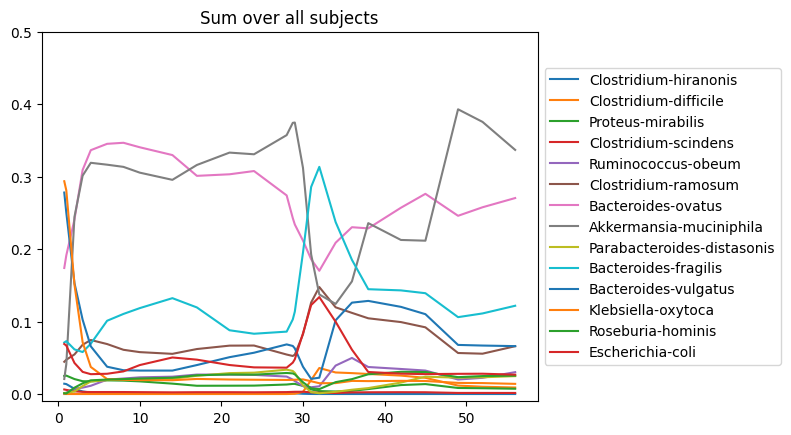

In [16]:
# plot P for all subjects
fig, ax = plt.subplots()
for i in np.arange(n_taxa):
    ax.plot(T[0], P[0][:,i], label = names[i])
# ax[sub].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Sum over all subjects")
ax.set_ylim(-0.01, 0.5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Additional Analysis regarding choose_denom and ALR

In [17]:
# denom check (from choose_denom(P))
np.seterr(divide="ignore", invalid="ignore")
vars = []
log_change = None
for p in P:
    s = p.sum(axis=1,keepdims=True)
    s[s==0] = 1
    deltas = np.log( (p/s)[1:] ) - np.log( (p/s)[:-1] )
    if log_change is None:
        log_change = deltas
    else:
        log_change = np.vstack((log_change, deltas))
np.seterr(divide="warn", invalid="warn")
# pick taxon with smallest change in log proportion
min_var = np.inf
ntaxa = log_change.shape[1]
for i in range(ntaxa):
    if not np.all(np.isfinite(log_change[:,i])):
        continue
    var = np.var(log_change[:,i])
    vars.append(var)

In [18]:
choose_denom(P)

6

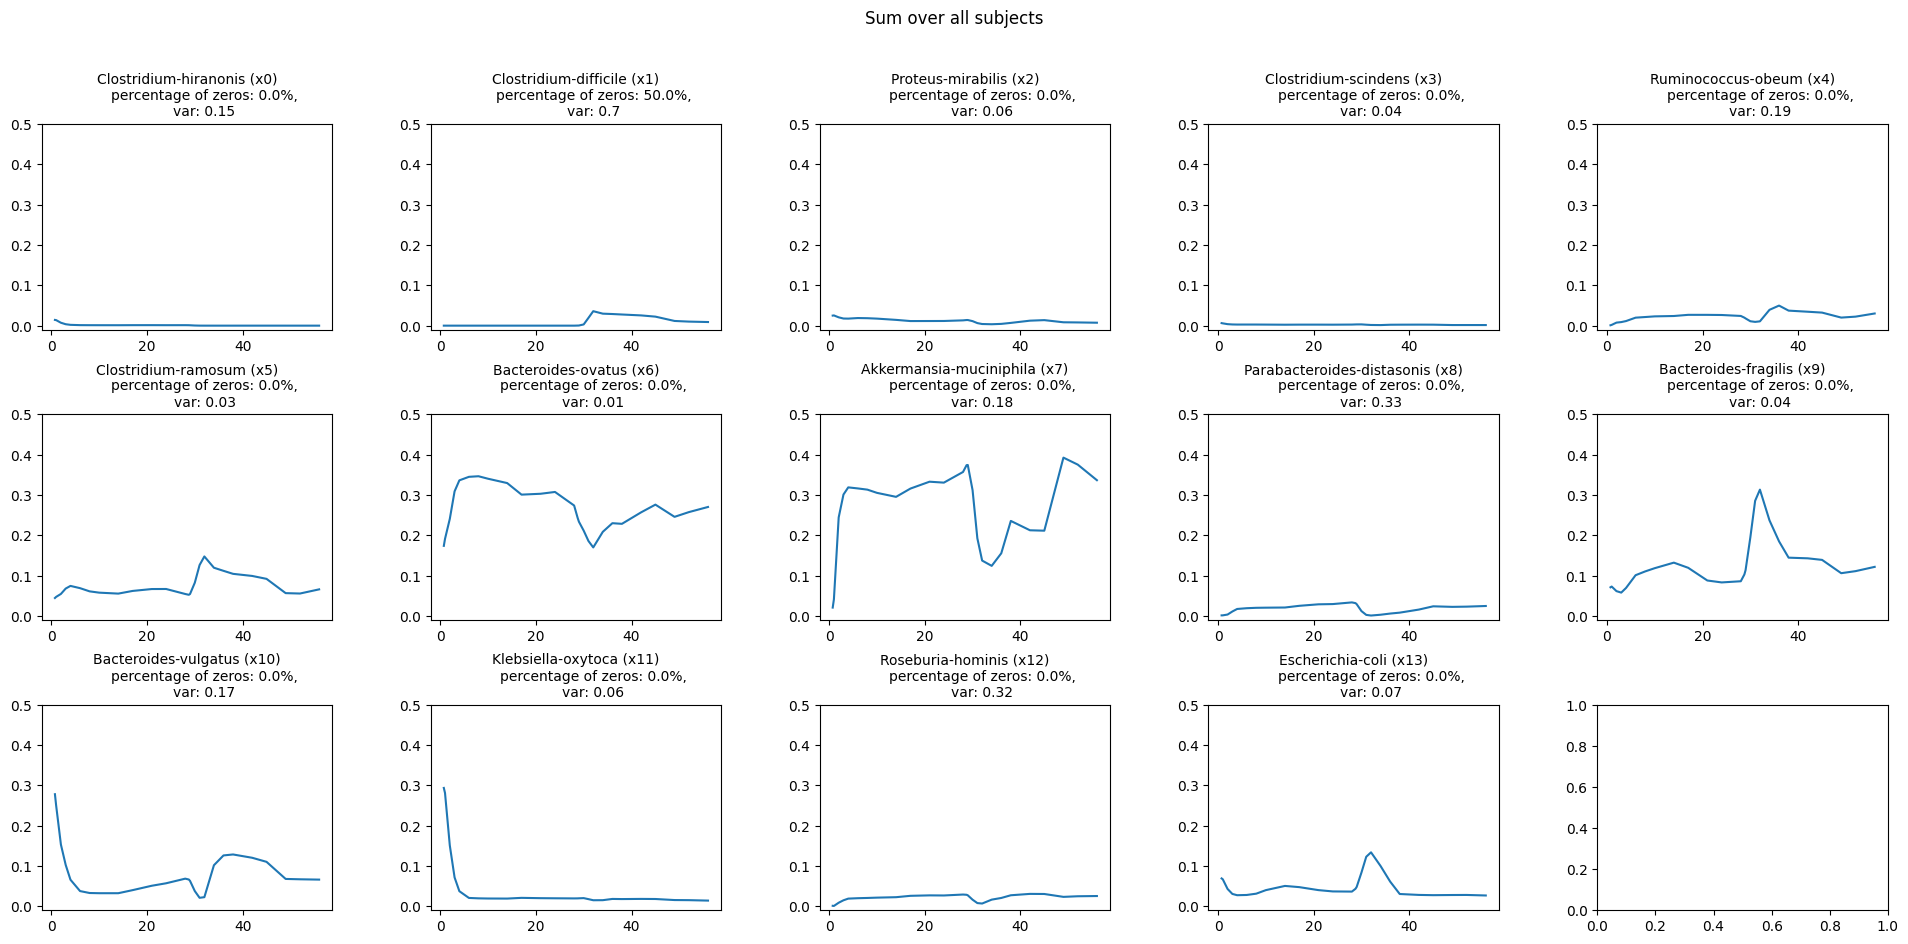

In [20]:
# plot time series with all otus
n_row = 3
n_col = 5
fig, axs = plt.subplots(n_row, n_col)
fig.set_figwidth(20)
fig.set_figheight(10)
fig.suptitle("Sum over all subjects")
fig.tight_layout(pad=3.0)
ind=0
for i in np.arange(n_taxa):
    # plot each taxon timeline separately
    axs[math.floor(ind/n_col), (ind%n_col)].plot(T[0], P[0][:,i])
    axs[math.floor(ind/n_col), (ind%n_col)].set_title(f"""{names[i]} (x{i})
        percentage of zeros: {round(sum(Y[0][:,i] == 0)/n_samples*100, 1)}%,
        var: {round(vars[i],2)}""")
    axs[math.floor(ind/n_col), (ind%n_col)].title.set_size(10)
    axs[math.floor(ind/n_col), (ind%n_col)].set_ylim([-0.01, 0.5])
    ind += 1

### choose final denominator and do alr transformation

In [21]:
# use choose_denom function to select denominator
# denom = choose_denom(P)
denom = 3
print(denom)

ALR = construct_alr(P, denom)

3


In [22]:
denom_name = names.pop(denom)

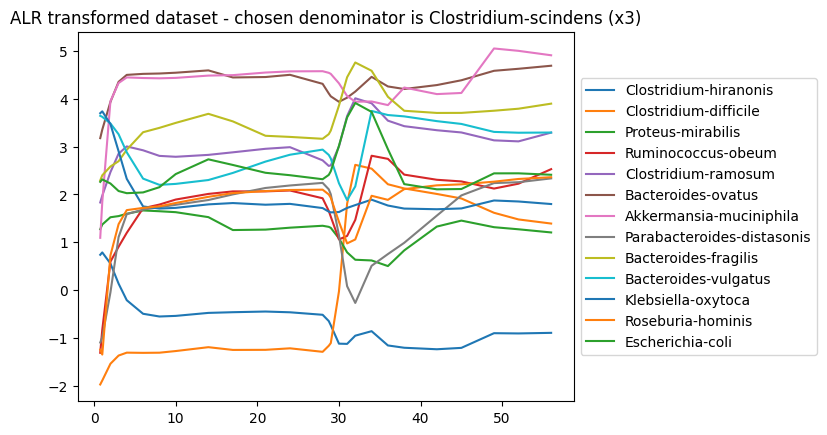

In [28]:
# plot alr transformed time series
fig, ax = plt.subplots()
for i in np.arange(n_taxa-1):
    ax.plot(T[0], ALR[0][:,i], label = names[i])
ax.set_title(f"ALR transformed dataset - chosen denominator is {denom_name} (x{denom})")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### save ALR as csv file

In [29]:
# save alr as csv file
ALR = construct_alr(P, denom)
df_ALR = pd.DataFrame(ALR[0])
df_ALR.insert(0, "Time", T[0])
df_ALR.to_csv(f'{filepath}ALR_denom{denom}_ts_bucci_subject_all_rel_counts_denoised.csv', index=False)

## CLV Analysis

In [30]:
# estimated previously
r_A = 0.25
r_g = 4
r_B = 0.125

In [35]:
clv = CompositionalLotkaVolterra(P, T, U, pseudo_count=1e-5)

In [31]:
clv.r_A = r_A
clv.r_g = r_g
clv.r_B = r_B

In [32]:
clv.alpha = 1
clv.train()

In [34]:
estimate_elastic_net_regularizers_cv(clv.X, clv.P, clv.U, clv.T, clv.denom, folds=10, no_effects=T)
# clv.train_ridge()
# A_clv, g_clv, B_clv = clv.get_params()

# print(A_clv, g_clv, B_clv)

	r (0.1, 0.1, 0.1, 0) sqr error 0.0


(0.1, 0.1, 0.1, 0)

In [36]:
clv.train()

	r (0.1, 0.1, 0.1, 0.1) sqr error 0.0


In [37]:
clv.A

array([[-0.05748497,  0.26602006, -0.12881841, -0.02174702,  0.52943605,
         0.11927471,  1.00227276, -0.20383055,  0.19804632, -0.10924537,
        -0.17112756, -1.3175744 ,  0.25749495, -0.58388967],
       [ 0.        , -0.44940781,  0.07066451,  0.03625941, -0.16664959,
        -0.4668158 , -1.8970262 ,  1.7339294 ,  0.43258796,  0.42675556,
        -0.37911266, -0.29455486,  0.16325916,  0.80277114],
       [-0.02784483,  0.13835098, -0.08129193, -0.00355153,  0.31667734,
         0.16615789,  0.23657006, -0.01704028,  0.0550542 , -0.15312728,
         0.1624792 , -0.73628087,  0.13243011, -0.26967758],
       [-0.04097562,  0.08386575, -0.07496274, -0.00578577,  0.26655101,
         0.11672944,  0.19181736,  0.3121972 ,  0.09159277,  0.11644434,
        -0.2535648 , -1.01596171,  0.1355352 , -0.10314429],
       [ 0.09270051, -0.25207986,  0.09969857,  0.01499674, -0.48826477,
        -0.42850258, -0.1066429 , -0.7087263 , -0.0300517 , -0.1885756 ,
         0.19305461,  1.87